In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import calendar
import random
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')
# visualization basic configuration
%matplotlib inline
base_color = sb.color_palette()[0]
standard = [14.70, 8.27]
panorama = [20,8.27]

plt.rcParams.update({'font.size': 22})

In [2]:
trans = pd.read_csv('./transactions.csv')
cc = pd.read_csv('./cc_info.csv')

In [3]:
trans.head(3)

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004


In [4]:
cc.head(3)

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000


# Q1: identify those users that in the your data set never went above the monthly credit card limit


How the function works:
    - join the transactions and credit card info tables to get the transactions amount and credit card limit in one table.
    - calculate the total sum of transactions for each credit card per month --> 'cumulative sum'
    - calculate the difference between monthly total sum and credit card limit --> 'remaining credit'
    - if remaining credit is positive: the user is below his limit, and above otherwise.

In [124]:
def get_users(transactions, credit_info, credit_amount = 1):
    """
    This function return users whose cumulative transactions amount aither below or above their credit limit.
    params:
        tranactions (dataframe),
        credit_info (dataframe),
        credit_amount: if 1, users with cumulative amount bigger or equal to zero are returned
                       if -1, users with cumulative amount lower than zero are returned
                       otherwise, raise and exception
    """
    df = pd.merge(
                transactions,
                credit_info,
                how = "inner",
                on = 'credit_card')
    df['month'] = pd.to_datetime(df['date']).dt.month
    
    cumulative_amount = pd.pivot_table(df, index=['credit_card','month'],values=['transaction_dollar_amount'],aggfunc=np.sum).rename(columns={'transaction_dollar_amount':'total_monthly_spent'})
    credit_limit = pd.pivot_table(df, index=['credit_card', 'month'],values=['credit_card_limit'],aggfunc=np.mean).rename(columns={'credit_card_limit':'credit_card_limit'})
    
    grouped_data = pd.concat([cumulative_amount, credit_limit],axis=1)
    grouped_data['remaining_credit'] = grouped_data['credit_card_limit'] - grouped_data['total_monthly_spent']
    
    returned_columns = ['total_monthly_spent','credit_card_limit','remaining_credit']
    
    if credit_amount == 1:
         return grouped_data[grouped_data['remaining_credit'] >= 0][returned_columns]
    elif credit_amount == -1:
        return grouped_data[grouped_data['remaining_credit'] < 0][returned_columns]
    else:
        raise Exception("credit limit should be one of [1,-1] values, while " + str(credit_amount) + " is passed") 

In [125]:
get_users(trans, cc, credit_amount = -1)

total_monthly_spent  credit_card_limit  \
credit_card      month                                           
1106824181265726 8                  6734.92               6000   
                 9                  7419.42               6000   
                 10                 7483.05               6000   
1175962294549313 8                 15809.71              14000   
                 9                 14370.20              14000   
...                                     ...                ...   
9727202337611852 8                 20207.03              20000   
                 10                20077.76              20000   
9737219864179988 8                 16156.60              16000   
9999757432802760 9                  6814.72               6000   
                 10                 6864.03               6000   

                        remaining_credit  
credit_card      month                    
1106824181265726 8               -734.92  
                 9              -1419.42  
                 10             -1483.05  
1175962294549313 8              -1809.71  
                 9               -370.20  
...                                  ...  
9727202337611852 8               -207.03  
                 10               -77.76  
9737219864179988 8               -156.60  
9999757432802760 9               -814.72  
                 10              -864.03  

[226 rows x 3 columns]

# Q2: Build a function that for each day, returns a list of users who went above their credit card monthly limit on that day

How the function works:
    - same as Q1, but now the sum is calculated as cumsum. In other words, for each transaction the cumulative sum is the sum of this transaction and all transaction happened before in the same month.
    - from step 1, calculate the remaining credit after each transactions.
    - once the remaining credit is below zero, a flag is raised.
    - we return the credit card whose flag is raised in the day passed to the function.

In [136]:
def users_above_limit_by_day(transactions, credit_info, day):
    day = pd.Timestamp(day[0],day[1],day[2])
    
    df = pd.merge(
                transactions,
                credit_info,
                how = "inner",
                on = 'credit_card')
    
    df['day'] = pd.to_datetime(df['date']).dt.date
    df['month'] = pd.to_datetime(df['date']).dt.month

    
    df_until_day  = df[df['day'] <= day]
    
    df_until_day_grouped = df_until_day.groupby(['credit_card','month','credit_card_limit','day']).agg({'transaction_dollar_amount':'sum'})
    
    df_until_day_grouped['month_cumsum'] = df_until_day_grouped.groupby(level=[0,1]).cumsum()
    
    df_until_day_grouped = df_until_day_grouped.reset_index(level = [2,3])
    
    df_until_day_grouped['remaing_credit'] = df_until_day_grouped['credit_card_limit'] - df_until_day_grouped['month_cumsum']
    
    df_flaged = df_until_day_grouped[df_until_day_grouped['remaing_credit'] <= 0]
    
    answer = df_flaged[df_flaged['day'] ==  day]
    
    
    return answer

In [137]:
users_above_limit_by_day(trans, cc, (2015,8,28))

,,credit_card_limit,day,transaction_dollar_amount,month_cumsum,remaing_credit
credit_card,month,,,,,
1106824181265726,8,6000,2015-08-28,284.35,6274.06,-274.06
1175962294549313,8,14000,2015-08-28,438.00,14252.67,-252.67
1460880989446247,8,20000,2015-08-28,832.84,22639.83,-2639.83
1850995745665541,8,3000,2015-08-28,139.11,3350.99,-350.99
2032689281683871,8,4000,2015-08-28,285.40,4262.93,-262.93
2245942585429940,8,10000,2015-08-28,721.72,13242.91,-3242.91
2366928097135853,8,14000,2015-08-28,1329.25,17316.16,-3316.16
2756688131944353,8,15000,2015-08-28,773.84,16407.60,-1407.60
2850146878241916,8,4000,2015-08-28,73.93,4201.98,-201.98


# Q3: Build a model that returns all transactions that seem unusual and are worth being investigated further.

After the interview feedback, we concluded that rule based model built on detecting frauds when seeing unsusal coordinates of the transaction is a suitable solution for this problem. The solution is as follows:

    - For each credit card, calculate the mean and standard deviation for the coordinates pair (Long, lat)
    - For each credit card, calculate the z-score using the calculated meand and std.
    - Flag any transaction that either its lat or long z-score is above a threshold of 3.

In [146]:
df = trans.copy()

In [71]:
df

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719
...,...,...,...,...,...
294583,9999757432802760,2015-09-10 19:43:33,127.23,-82.360952,32.978497
294584,9999757432802760,2015-08-06 21:00:13,84.90,-82.322721,33.061071
294585,9999757432802760,2015-09-22 16:15:47,77.54,-82.442130,32.949983
294586,9999757432802760,2015-08-27 18:08:24,144.05,-82.398587,32.976162


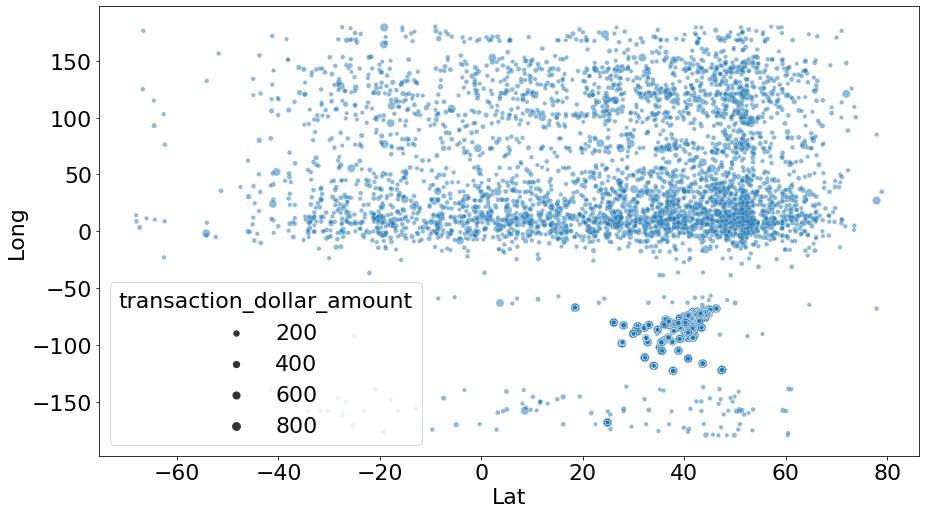

In [77]:
plt.figure(figsize = standard)
sb.scatterplot(x = df.Lat, y = df.Long, alpha = 0.5, size = df.transaction_dollar_amount)

the above plot is the long and lat points for all transaction in the data-set. This plot by it self does not tell much for this question. Yet, one can tell that the transactions amoun is relatively higher for lat between [20,60] and long between [-150,-50].

However, since this is not very useful for our problem. let's sample a random credit card and plot its transactions coordinates.

In [ ]:
random_credit_card = df.sample()['credit_card'].values[0]
random_card_data = df[df['credit_card'] == random_credit_card ]

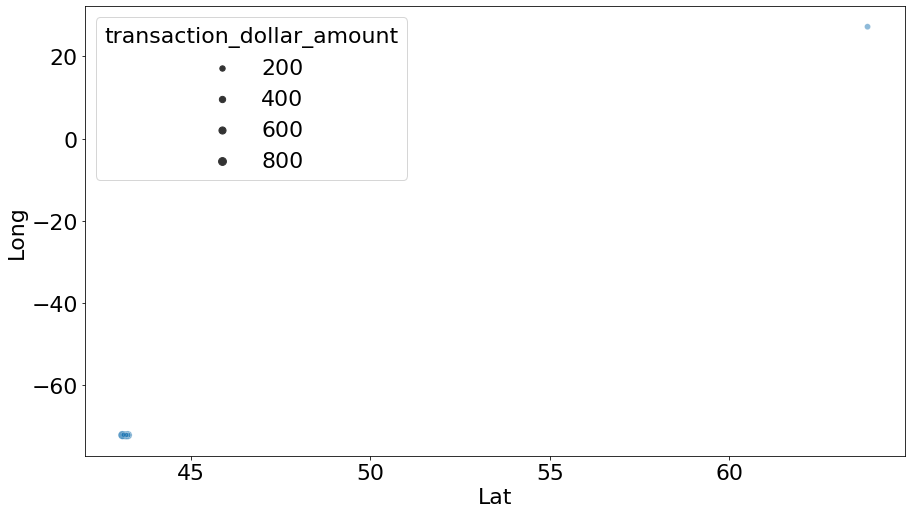

In [89]:
plt.figure(figsize = standard)
sb.scatterplot(data = random_card_data , x = 'Lat', y = 'Long', alpha = 0.5, size = 'transaction_dollar_amount')

As can be seen, there is a point in the upper right corner that indicate that there is a transaction which is done at unusal coordinates for this user. This transaction should raise a flag for further investigation.

In [188]:
def aggregate(df, columns, func, suffix):
    
    renaming_dict = {col: col+"_"+suffix for col in columns}
    param_coordinates = pd.pivot_table(df, 
                                        index=['credit_card'],
                                       values=columns,
                                       aggfunc=func).rename(columns = renaming_dict)
    return param_coordinates


def calc_zscore(df, columns):
    for col in columns:
        df[col+'_zscore'] = (df[col] - df[col+"_mean"]) / df[col+"_std"]
    return df
    
def calc_lat_zscore(df, columns):
    
    df = calc_zscore(df, columns)
    df["coordinates_zscore_outlier"] = ((abs(df["Long_zscore"])>3).astype(int) + (abs(df["Lat_zscore"])>3).astype(int)) / 2
    df = df[df["coordinates_zscore_outlier"]  == 1]
        
    return df
    
    
def coordinates_rule_anomilies(data):
    df = data.copy()
    columns = ['Long', 'Lat']
    
    mean_coordinates = aggregate(df, columns, np.mean, 'mean')
    std_coordinates = aggregate(df, columns, np.std, 'std')
    
    coordinates_params = pd.concat([mean_coordinates, std_coordinates],axis=1)
    
    df = pd.merge(
        df,
        coordinates_params,
        on = 'credit_card',
        how = 'inner')

    df = calc_lat_zscore(df, columns)
    
    return df[data.columns]



In [189]:
coordinates_rule_anomilies(df)

,credit_card,date,transaction_dollar_amount,Long,Lat
128,1003715054175576,2015-10-25 00:11:25,87.77,102.032338,-32.343578
141,1003715054175576,2015-09-25 20:51:42,53.31,-7.373733,-11.785999
306,1013870087888817,2015-10-06 00:34:58,40.52,110.386103,52.238635
484,1013870087888817,2015-08-07 17:47:29,66.33,31.083820,0.500182
495,1013870087888817,2015-10-15 18:20:18,109.28,15.466472,51.695983
...,...,...,...,...,...
293735,9981251982982618,2015-08-20 17:38:51,83.15,107.024289,5.903593
293776,9981251982982618,2015-10-10 22:25:50,82.09,3.183700,55.997719
293828,9981251982982618,2015-08-06 22:18:53,71.17,8.566971,52.557861
293900,9981251982982618,2015-10-20 20:23:37,116.08,123.446448,-0.895321


To further investigate the output of this rule based fraud detection. Let's examine the transactions of the first credit card in the output.

In [197]:
df = trans.copy()

In [198]:
anomilies = coordinates_rule_anomilies(df)
df['outlier'] = 0
df.loc[df.index.isin(anomilies.index),'outlier']= 1

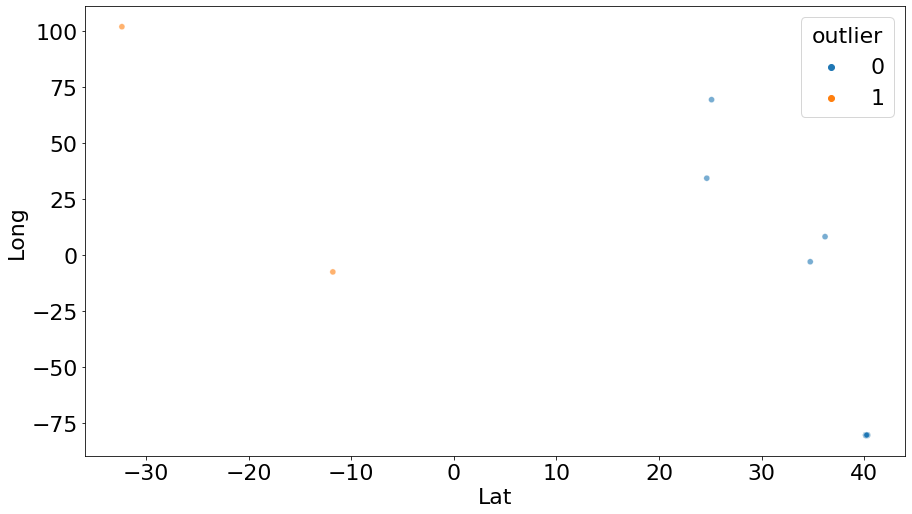

In [206]:
test_credit_card = df[df['credit_card'] == 1003715054175576]
plt.figure(figsize = standard)
sb.scatterplot(data = test_credit_card , x = 'Lat', y = 'Long', alpha = 0.6, hue = 'outlier')

Almost all the user transactions are around Lat = 40, Long = -75. Some other are in different coordinates yet not as far as the transaction in the upper left corner of the plot. According to z-score with threshold = 3. This transaction is flaged as fraud.